In [1]:
import pandas as pd
from PIL import Image
import io
import numpy as np
import pickle
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from torchvision import transforms
from torchsummary import summary
import torchvision.models as models
import scipy


os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
if torch.cuda.is_available():
  torch.set_default_device('cuda')
  device = 'cuda'
else:
  device = 'cpu'

start

In [2]:
cntry_str =  np.load('cntry_str.npy', allow_pickle=True)

In [3]:
fromfile = True
if fromfile:
    df = pd.read_parquet('data', engine='fastparquet')
    shuffled_df = df[['image.bytes', 'country_iso_alpha2']].sample(frac=1)
    shuffled_df.to_parquet('shuffled_data.parquet')
df = pd.read_parquet('shuffled_data.parquet', engine='fastparquet')
df = df[df.country_iso_alpha2.isin(cntry_str)]
rows = df.shape[0]

In [4]:
#df.country_iso_alpha2.value_counts()

In [5]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(io.BytesIO(row['image.bytes']))
        if self.transforms:
            image = self.transforms(image)
        return image.to(device), np.searchsorted(cntry_str, row['country_iso_alpha2'])

In [6]:
ds = ImageDataset(df, transforms.Compose([transforms.Resize(448),  transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
#transforms.RandomCrop((384, 2071))
#transforms.RandomHorizontalFlip()
dl = torch.utils.data.DataLoader(ds, batch_size=16, num_workers=0) 

tensor(42, device='cuda:0')
PL


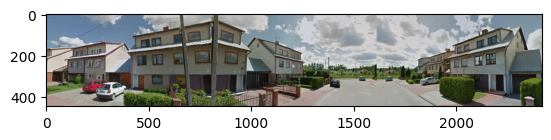

tensor(12, device='cuda:0')
CL


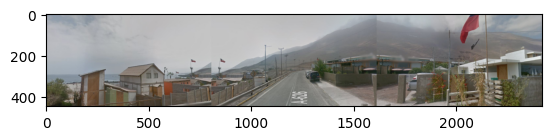

tensor(36, device='cuda:0')
MX


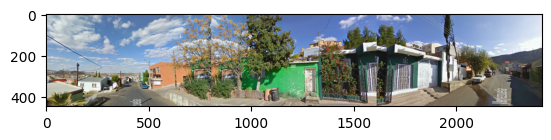

tensor(33, device='cuda:0')
KR


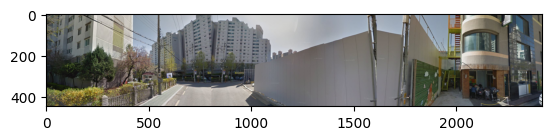

tensor(52, device='cuda:0')
TW


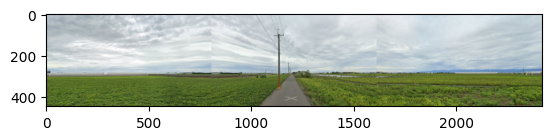

tensor(35, device='cuda:0')
LV


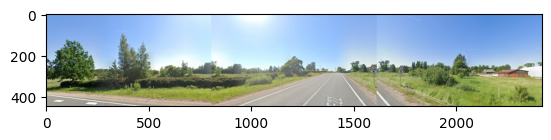

tensor(12, device='cuda:0')
CL


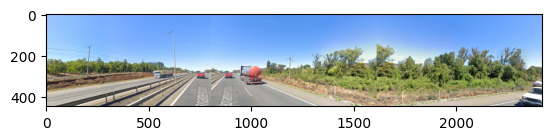

tensor(39, device='cuda:0')
NO


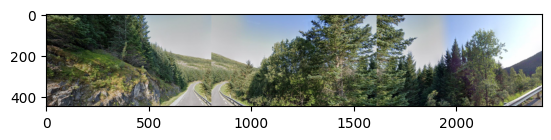

tensor(7, device='cuda:0')
BR


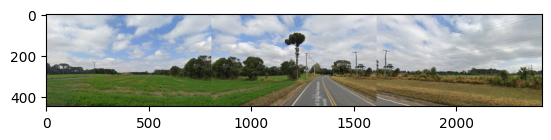

tensor(6, device='cuda:0')
BG


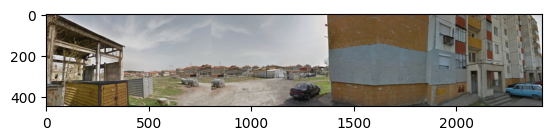

tensor(16, device='cuda:0')
DK


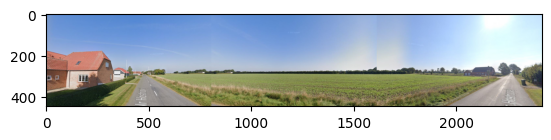

tensor(1, device='cuda:0')
AE


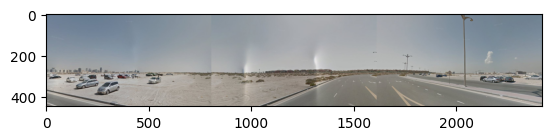

tensor(35, device='cuda:0')
LV


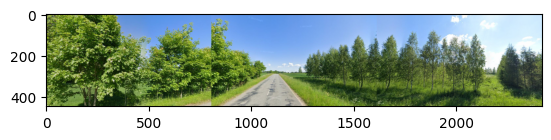

tensor(46, device='cuda:0')
SE


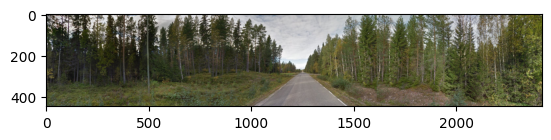

tensor(42, device='cuda:0')
PL


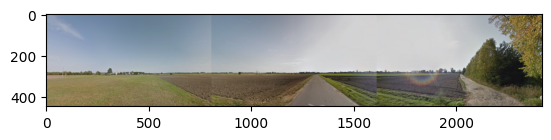

tensor(15, device='cuda:0')
DE


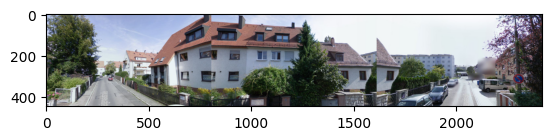

In [7]:
for images, labels in dl:
    for i in range(16):
        print(labels[i])
        print(cntry_str[labels[i]])
        plt.imshow(images[i].to('cpu').transpose(0,2).transpose(0,1) * 0.5 + 0.5)
        plt.show()
    break

generator, dataset, dataloader

In [8]:
generator1 = torch.Generator('cuda') #.manual_seed(42)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(ds, [0.7, 0.2, 0.1], generator=generator1)

In [9]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, num_workers=0)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, num_workers=0)

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # If input and output dimensions are different, use 1x1 convolution to match dimensions
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=5, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Sequential()

    def forward(self, x):
        residual = x

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        # Adjust the dimensions of the shortcut to match the dimensions of the output
        residual = self.shortcut(residual)

        out += residual
        out = F.relu(out)
        return out

class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()

        self.pool = nn.MaxPool2d(3, 3)

        self.conv1 = ResidualBlock(16, 16, 3)
        self.conv2 = ResidualBlock(16, 16, 5)
        self.conv3 = ResidualBlock(16, 16, 5)

        self.fc1 = nn.Linear(2944, 600)
        self.fc2 = nn.Linear(600, 120)
        self.fc3 = nn.Linear(120, 56)

        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def get_loss(self, x):
      self.train()
      return self.loss_fn(self(x[0]), x[1])
    
    @torch.no_grad()
    def calc_loss(self, dataloader):
      self.eval()
      total_loss = 0.0
      i = 0
      for inputs, targets in dataloader:
          inputs, targets = inputs.to(device), targets.to(device)
          outputs = self(inputs)
          loss = self.loss_fn(outputs, targets)
          total_loss += loss.item()
          i += 1
          if i > 10:
             break
          
      return total_loss / i #len(dataloader)

In [11]:
class Model2(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)

        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 128, 3)
        self.conv5 = nn.Conv2d(128, 256, 5)


        self.fc1 = nn.Linear(4608, 600)
        self.fc2 = nn.Linear(600, 120)
        self.fc3 = nn.Linear(120, 56)

        
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))

        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def get_loss(self, x):
      self.train()
      return self.loss_fn(self(x[0]), x[1])
    
    @torch.no_grad()
    def calc_loss(self, dataloader):
      self.eval()
      total_loss = 0.0
      i = 0
      for inputs, targets in dataloader:
          inputs, targets = inputs.to(device), targets.to(device)
          outputs = self(inputs)
          loss = self.loss_fn(outputs, targets)
          total_loss += loss.item()
          i += 1
          if i > 10:
             break
          
      return total_loss / i #len(dataloader)

model = Model2().to(device)

total_params = sum(
	param.numel() for param in model.parameters()
)
#print(total_params)
#summary(model, (3, 128, 691))

In [12]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)

        self.conv1 = nn.Conv2d(3, 3, 3)
        self.conv2 = nn.Conv2d(3, 4, 5)
        self.conv3 = nn.Conv2d(4, 8, 5)
        self.conv4 = nn.Conv2d(8, 8, 5)

        self.fc1 = nn.Linear(1248, 600)
        self.fc2 = nn.Linear(600, 120)
        self.fc3 = nn.Linear(120, 56)
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def get_loss(self, x, y):
      self.train()
      return self.loss_fn(self(x), y)
    
    @torch.no_grad()
    def calc_loss(self, x, y):
      self.eval()
      return self.loss_fn(self(x), y)

In [13]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(3, 3)

        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.conv3 = nn.Conv2d(32, 64, 5)

        self.fc1 = nn.Linear(2944, 600)
        self.fc2 = nn.Linear(600, 120)
        self.fc3 = nn.Linear(120, 56)

        
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def get_loss(self, x):
      self.train()
      return self.loss_fn(self(x[0]), x[1])
    
    @torch.no_grad()
    def calc_loss(self, dataloader):
      self.eval()
      total_loss = 0.0
      i = 0
      for inputs, targets in dataloader:
          inputs, targets = inputs.to(device), targets.to(device)
          outputs = self(inputs)
          loss = self.loss_fn(outputs, targets)
          total_loss += loss.item()
          i += 1
          if i > 10:
             break
          
      return total_loss / i #len(dataloader)

model3

In [14]:
class Model3(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.backbone = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V2)
        for param in self.backbone.parameters():
            param.requires_grad = False
        for param in self.backbone.fc.parameters():
            param.requires_grad = True
        self.layer1 = nn.Linear(1000, 56)
        #self.layer2 = nn.Linear(500, 200)
        #self.layer3 = nn.Linear(200, 100)
        #self.layer4 = nn.Linear(100, 56)
        

    def forward(self, x):
        x = self.backbone(x)
        x = self.layer1(x)
        #x = self.layer2(x)
        #x = self.layer3(x)
        #x = self.layer4(x)

        return x


In [15]:
# model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1).to(device)
model = Model3().to(device)

In [16]:
optimizer = optim.Adam(model.parameters())

In [17]:
summary(model, (3, 128, 691))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 64, 346]           9,408
       BatchNorm2d-2          [-1, 64, 64, 346]             128
              ReLU-3          [-1, 64, 64, 346]               0
         MaxPool2d-4          [-1, 64, 32, 173]               0
            Conv2d-5          [-1, 64, 32, 173]           4,096
       BatchNorm2d-6          [-1, 64, 32, 173]             128
              ReLU-7          [-1, 64, 32, 173]               0
            Conv2d-8          [-1, 64, 32, 173]          36,864
       BatchNorm2d-9          [-1, 64, 32, 173]             128
             ReLU-10          [-1, 64, 32, 173]               0
           Conv2d-11         [-1, 256, 32, 173]          16,384
      BatchNorm2d-12         [-1, 256, 32, 173]             512
           Conv2d-13         [-1, 256, 32, 173]          16,384
      BatchNorm2d-14         [-1, 256, 

Training

In [18]:

# költségek tárolása, hogy tudjuk majd őket ábrázolni
tr_losses = []
val_losses = []
criterion = nn.CrossEntropyLoss()

# tanítás
for epoch in range(30):
  for i, iter in enumerate(train_dataloader):
      
      #print(iter[1])

      # train mode, gradiensek nullázása
      model.train()
      optimizer.zero_grad()

      # backprop, param update
      train_loss = criterion(model(iter[0]), iter[1])  # model.get_loss(iter)
      train_loss.backward()
      optimizer.step()

      if i % 20 == 0:
        tr_losses.append(train_loss.item())
        with torch.no_grad():
            model.eval()
            total_loss = 0.0
            sum = 0; count = 0
            j = 0
            for inputs, targets in val_dataloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                total_loss += loss.item()

                sum += torch.sum(torch.argmax(outputs, 1) == targets); count += targets.shape[0]
                

                j += 1
                if j > 3:
                  break
            val_loss = total_loss / j
        val_losses.append(val_loss)
        print(f"epoch {epoch}, step {i}: train loss {train_loss:.5f}, val loss: {val_loss:.5f}, val acc: {sum / count:.5f}")

#print(f"epochs: {iter+1}, train loss {train_loss:.2f}, val loss: {val_loss:.2f}")

epoch 0, step 0: train loss 4.06821, val loss: 4.01776, val acc: 0.00781
epoch 0, step 20: train loss 4.14360, val loss: 3.77945, val acc: 0.09375
epoch 0, step 40: train loss 3.45816, val loss: 3.64983, val acc: 0.10938
epoch 0, step 60: train loss 3.93018, val loss: 3.44039, val acc: 0.14844
epoch 0, step 80: train loss 3.26886, val loss: 3.50868, val acc: 0.12500
epoch 0, step 100: train loss 3.08443, val loss: 3.27005, val acc: 0.23438
epoch 0, step 120: train loss 3.10788, val loss: 3.30480, val acc: 0.22656
epoch 0, step 140: train loss 3.21521, val loss: 3.16297, val acc: 0.17969
epoch 0, step 160: train loss 2.94867, val loss: 3.23813, val acc: 0.14844
epoch 0, step 180: train loss 3.10033, val loss: 3.09266, val acc: 0.23438
epoch 0, step 200: train loss 3.22387, val loss: 3.15501, val acc: 0.25781
epoch 0, step 220: train loss 3.14595, val loss: 2.90822, val acc: 0.23438
epoch 0, step 240: train loss 3.36133, val loss: 2.98724, val acc: 0.20312
epoch 1, step 0: train loss 2.9

KeyboardInterrupt: 

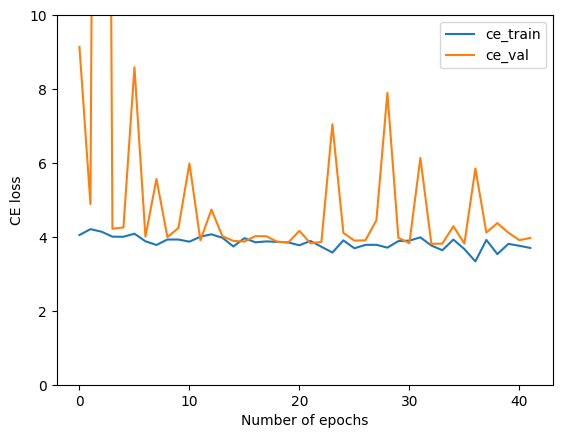

In [ ]:
plt.plot(tr_losses, label="ce_train")
plt.plot(val_losses, label="ce_val")
plt.xlabel("Number of epochs")
plt.ylabel("CE loss")
plt.ylim(0,10)
plt.legend()
plt.show()

In [ ]:
with torch.no_grad():
    model.eval()
    total_loss = 0.0
    j = 0

    sum = 0
    count = 0
    for inputs, targets in val_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_loss += loss.item()

        sum += torch.sum(torch.argmax(outputs, 1) == targets)
        count += targets.shape[0]

        j += 1
        if j > 10:
            break
    val_loss = total_loss / j
    print(sum / count)

tensor(0.3153, device='cuda:0')


ZA
guess: ZA


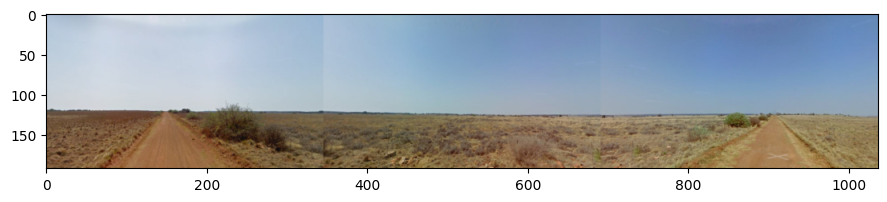

AU
guess: BD


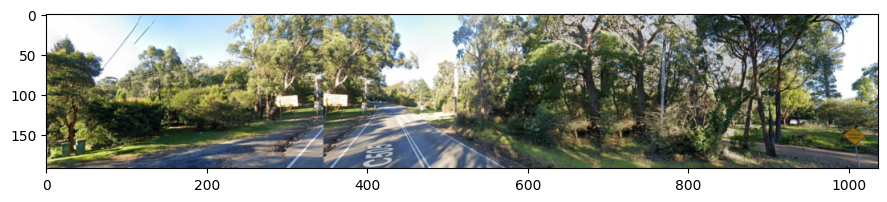

NL
guess: CZ


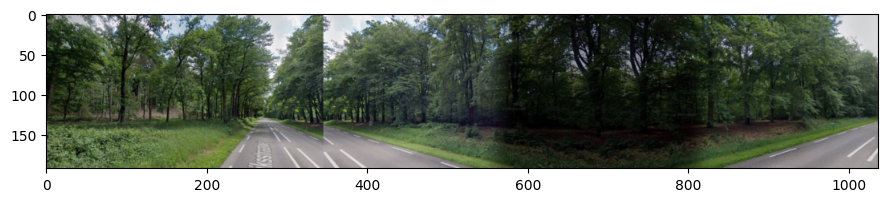

UA
guess: UA


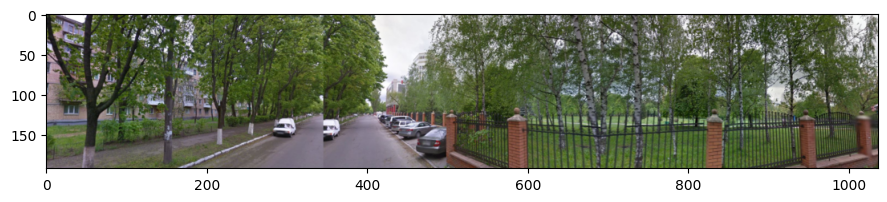

ID
guess: TH


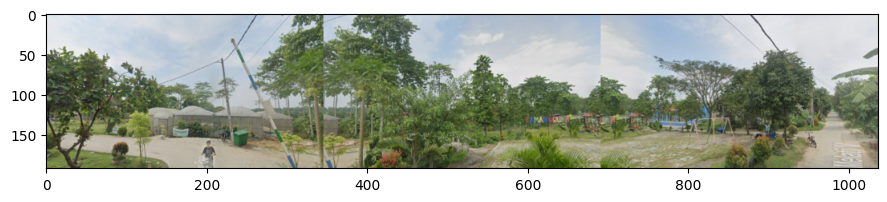

BE
guess: IE


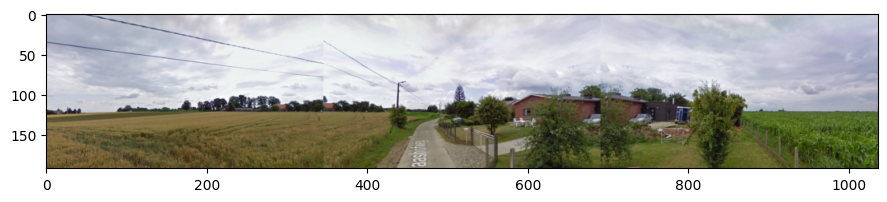

SG
guess: CO


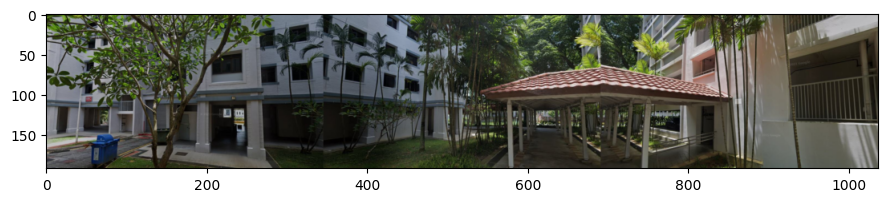

TW
guess: MY


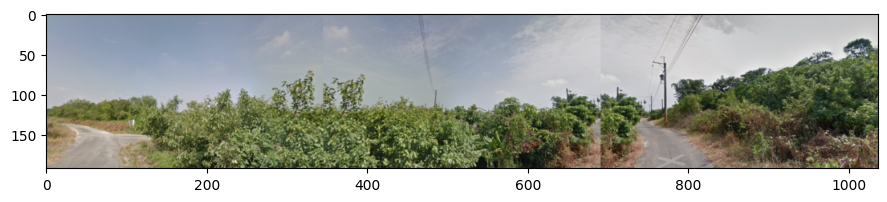

UA
guess: UA


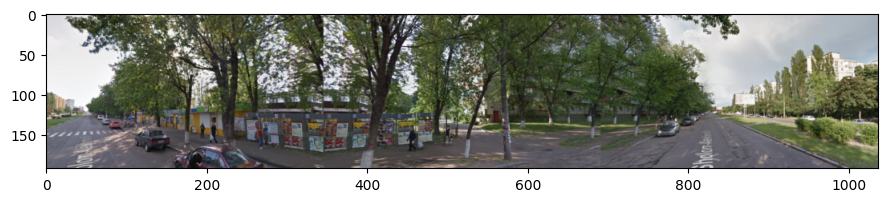

SK
guess: NL


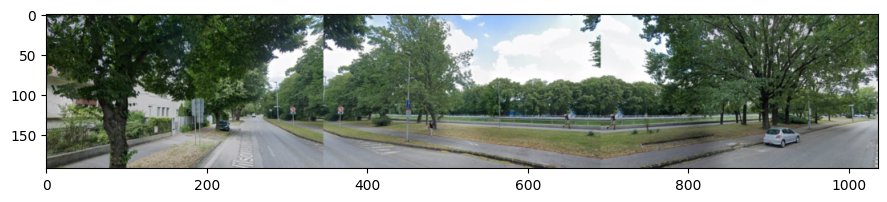

SG
guess: HK


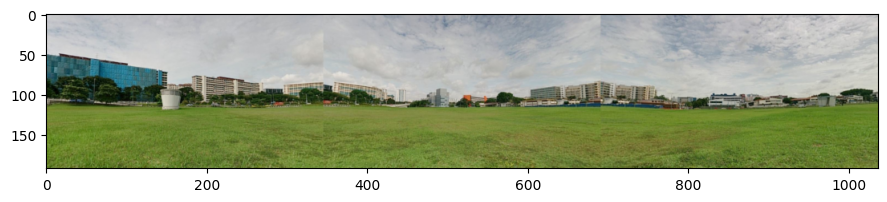

BD
guess: BD


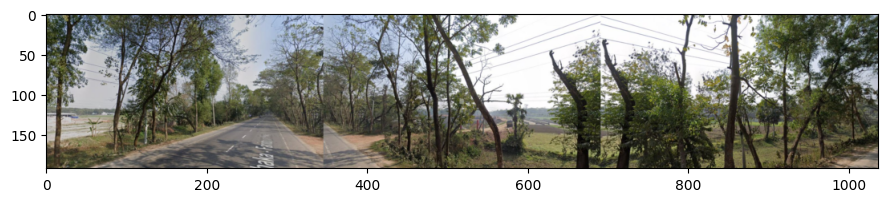

PT
guess: BG


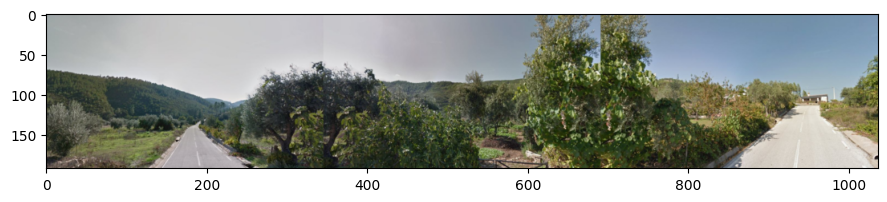

NZ
guess: ZA


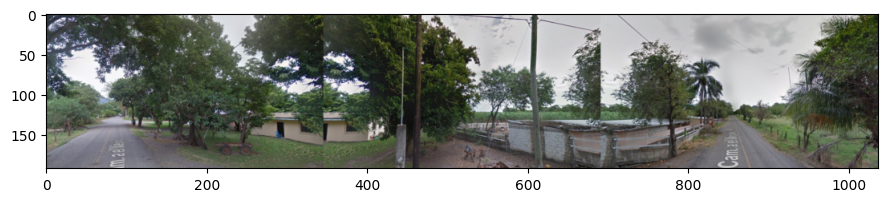

CA
guess: LV


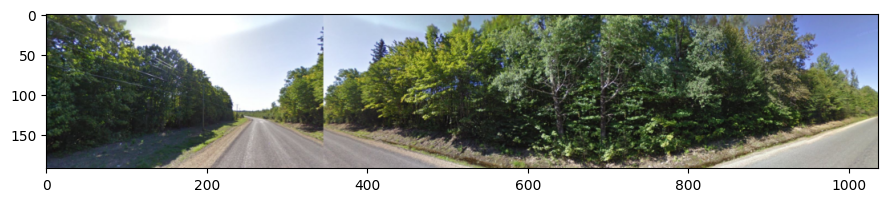

IS
guess: KH


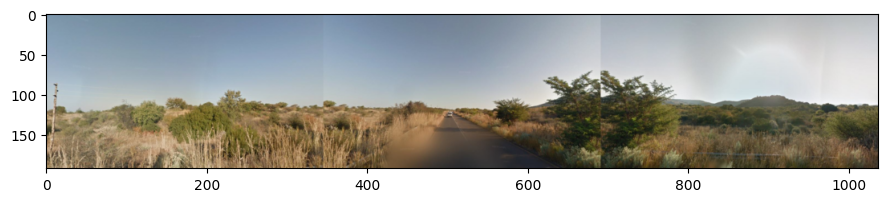

In [ ]:

for images, labels in val_dataloader:
    for i in range(16):
        print(cntry_str[labels[i]])
        print(f'guess: {cntry_str[torch.argmax(model(images[i][None, :])).item()]}')
        plt.figure(figsize = (50,2))
        plt.imshow(images[i].to('cpu').transpose(0,2).transpose(0,1))
        plt.show()
    break 
    